In [69]:
%reload_ext autoreload
%autoreload 2

In [70]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

In [78]:
from aegis.optim import perform_optimisation
from aegis.test_problems.synthetic_problems import Forrester, WangFreitas
from aegis.time_dists import *
from aegis.batch import BatchTS
from aegis.gen_training_data import generate_training_data_LHS

n_workers = 5
prob_function = WangFreitas
time_functions = {"const":consttime(),
                  "gauss":gausstime(prob_function(), scale=0.1),
                  "corr":corrtime(prob_function()),
                  "negcorr":negcorrtime(prob_function())}
time_function = time_functions["negcorr"]
acq_function = BatchTS
#acq_params = {"epsilon":0.1, "eta":0.1, "n_workers":n_workers, "n_features":2000}
acq_params = {}

problem_dim = prob_function().dim
acq_params = {
        "n_opt_samples": problem_dim * 1000,
        "n_opt_bfgs": 10,
    }

generate_training_data_LHS(prob_function, n_exp_start=1, n_exp_end=1)

perform_optimisation(prob_function, {}, 1, 5, n_workers, acq_function, acq_params, time_function)

File exists, skipping: data/WangFreitas_001.pt
Training data shape: torch.Size([2, 1])
 Submitted: 2 / 5 Completed: 2 / 5
SimExecutorJumpToCompletedJobProblemDependant.run_until_free(1)
SimExecutorJumpToCompletedJobProblemDependant.status:
{'n_free_workers': 5, 'n_busy_workers': 0, 'n_completed_tasks': 0, 'n_queue': 0, 't': 0, 'is_running': False}
Time: 0
SimExecutorJumpToCompletedJobProblemDependant.get_completed_jobs: Getting completed jobs
Best found hyperparameters:
	Lengthscale: [0.0840787]
	Outputscale: 0.4998985528945923
SimExecutorJumpToCompletedJobProblemDependant.status:
{'n_free_workers': 5, 'n_busy_workers': 0, 'n_completed_tasks': 0, 'n_queue': 0, 't': 0, 'is_running': False}
SimExecutorJumpToCompletedJobProblemDependant.queue_job: queuing job:
{'x': tensor([[0.2654]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f3d6debdbd0>}
Simulated runtime of job at tensor([[0.2654]], dtype=torch.float64):[7.41254137]
SimExecutorJumpToCompletedJobProblemDependant._

[Text(0.5, 1.0, 'Problem Function')]

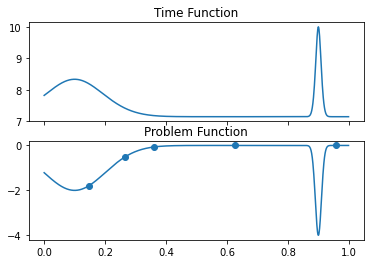

In [81]:
import matplotlib.pyplot as plt
import torch

prob_function = WangFreitas
time_functions = {"const":consttime(),
                  "gauss":gausstime(prob_function(), scale=0.1),
                  "corr":corrtime(prob_function()),
                  "negcorr":negcorrtime(prob_function())}

time_function = time_functions["negcorr"]

fig, axs = plt.subplots(2, sharex='all')

prob_function = prob_function()

x = np.arange(prob_function.lb, prob_function.ub, 0.001)
axs[0].plot(x, time_function(x))
axs[0].set(title="Time Function")

# Very scalable results fetching
data = torch.load("results/async_negcorr_5_workers=5_BatchTS_WangFreitas_run=001.pt")
X = data["Xtr"]
Y = data["Ytr"]

axs[1].plot(x, prob_function(x))
axs[1].scatter(X,Y)
axs[1].set(title="Problem Function")


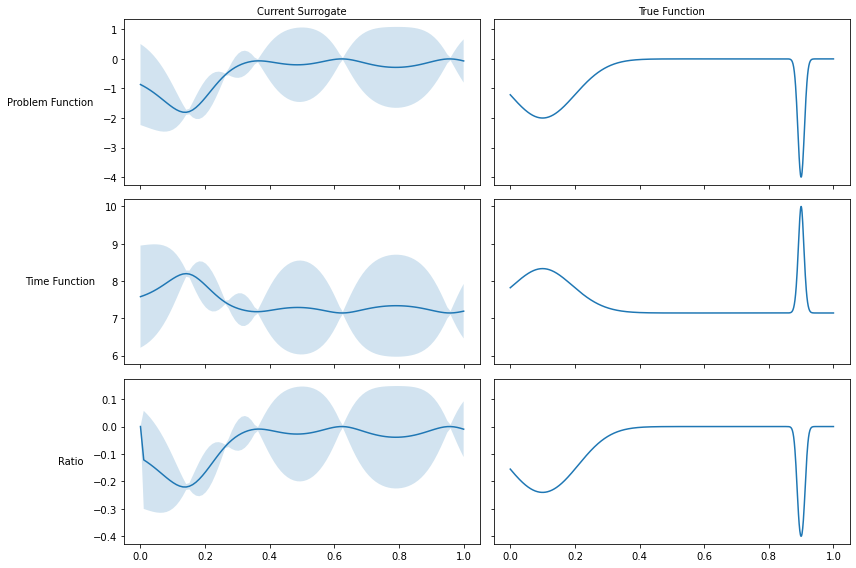

In [82]:
## Create a gp here and figure out how to get the variance/std deviation and mean from it, based on the above data
# autoreload
import aegis.gp as gp
from aegis.transforms import *
from ratiodist import ratiodist

ls_bounds = [1e-4, np.sqrt(X.shape[1])]
out_bounds = [1e-4, 10]

T_data = Transform_Standardize(Y)
train_y = T_data.scale_mean(Y)

Y_time = torch.as_tensor(time_function(X))
T_time = Transform_Standardize(Y_time)
train_y_time = T_time.scale_mean(Y_time)

model, likelihood = gp.create_and_fit_GP(
    X,
    train_y,
    ls_bounds,
    out_bounds,
    10
)

time_model, time_likelihood = gp.create_and_fit_GP(
    X,
    train_y_time,
    ls_bounds,
    out_bounds,
    10
)

# x must be as list or array of floats, NOT ints
test_x = torch.as_tensor(np.linspace(0, 1, 100).astype(float))

model.eval()
preds = model(test_x)
means = T_data.unscale_mean(preds.mean)
var = T_data.unscale_var(preds.variance)
means = torch.asarray(means)
var = torch.asarray(var)
stddev = np.sqrt(var)
y1 = means+2*stddev
y2 = means-2*stddev

subplts_kwargs = dict(sharex=True, sharey='row', figsize=(12,8))
fig, axs = plt.subplots(3, 2, **subplts_kwargs)

axs[0,0].plot(test_x, means)
axs[0,0].fill_between(test_x, y1, y2, alpha=0.2)

time_model.eval()
preds = time_model(test_x)
time_means = T_time.unscale_mean(preds.mean)
time_var = T_time.unscale_var(preds.variance)
time_means = torch.asarray(time_means)
time_var = torch.asarray(time_var)
time_stddev = np.sqrt(var)
y1 = time_means+2*stddev
y2 = time_means-2*stddev

axs[1,0].plot(test_x, time_means)
axs[1,0].fill_between(test_x, y1, y2, alpha=0.2)

acq_means = np.zeros(shape=(len(test_x),))
y1 = np.zeros(shape=(len(test_x),))
y2 = np.zeros(shape=(len(test_x),))

for i in range(1,len(test_x)):
    mu1 = means[i]
    sig1 = stddev[i]
    mu2 = time_means[i]
    sig2 = time_stddev[i]
    acq_means[i] = mu1 / mu2
    acq_var = ((mu1*mu1)/(mu2*mu2))*(((sig1*sig1)/(mu1*mu1))+((sig2*sig2)/(mu2*mu2)))
    acq_stddev = np.sqrt(acq_var)
    y1[i] = acq_means[i]+2*acq_stddev
    y2[i] = acq_means[i]-2*acq_stddev



axs[2,0].plot(test_x, acq_means)
axs[2,0].fill_between(test_x, y1, y2, alpha=0.2)

example_x = np.linspace(0,1,1000)
axs[0,1].plot(example_x, prob_function(example_x))
axs[1,1].plot(example_x, time_function(example_x))
axs[2,1].plot(example_x, prob_function(example_x) / time_function(example_x))

cols = ['Current Surrogate', 'True Function']
rows = ['Problem Function', 'Time Function', 'Ratio']

add_headers(fig, row_headers=rows, col_headers=cols, row_pad=1, col_pad=5, rotate_row_headers=False)

fig.tight_layout()

plt.show()
